In [141]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

## Data

### Upload and visualize data

Get the data for the stock Microsoft by specifying the stock ticker, start date, and end date

In [142]:
# Students are advised to use other data sources. This is just for the sake of brevity.
!pip install yfinance

In [143]:
import yfinance as yf

prices = yf.download('MSFT','2017-07-01','2020-06-30')

prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-07-03,69.330002,69.599998,68.019997,68.169998,64.250069,16165500
2017-07-05,68.260002,69.440002,68.220001,69.080002,65.107765,21176300
2017-07-06,68.269997,68.779999,68.120003,68.570000,64.627075,21117600
2017-07-07,68.699997,69.839996,68.699997,69.459999,65.465904,16878300
2017-07-10,69.459999,70.250000,69.199997,69.980003,65.956017,15014500


We'll use `Adjusted Close` to account for dividends and stock splits. Yahoo finance accounts for stock splits even in their `Close` price. However, some other data vendors don't (e.g. *Finam*). Pay attention.

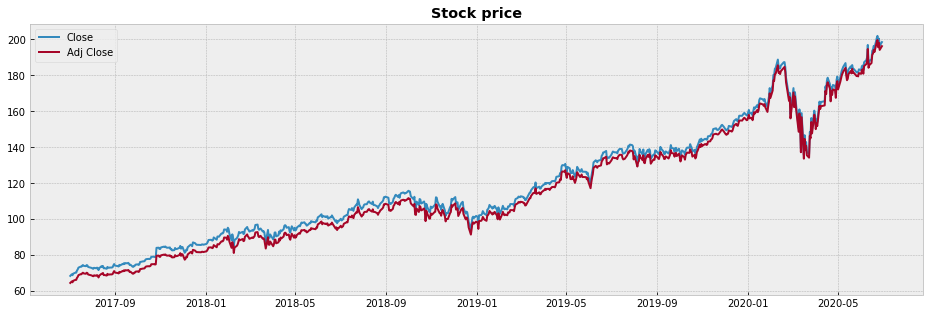

In [144]:
plot_fields =  ['Close', 'Adj Close']

fig = plt.figure(figsize=(16, 5))

plt.plot(prices[plot_fields])
plt.legend(plot_fields)

plt.title("Stock price", weight="bold")

plt.show()

### Preprocess prices and transform to returns

We convert datetime index to period

In [145]:
print(prices.index)

prices.index = prices.index.to_period(freq='d')

print(prices.index)

DatetimeIndex(['2017-07-03', '2017-07-05', '2017-07-06', '2017-07-07',
               '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
               '2017-07-14', '2017-07-17',
               ...
               '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
               '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29'],
              dtype='datetime64[ns]', name='Date', length=753, freq=None)
PeriodIndex(['2017-07-03', '2017-07-05', '2017-07-06', '2017-07-07',
             '2017-07-10', '2017-07-11', '2017-07-12', '2017-07-13',
             '2017-07-14', '2017-07-17',
             ...
             '2020-06-16', '2020-06-17', '2020-06-18', '2020-06-19',
             '2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
             '2020-06-26', '2020-06-29'],
            dtype='period[D]', name='Date', length=753, freq='D')


In [146]:
price = prices['Adj Close']

price.head()

Date
2017-07-03    64.250069
2017-07-05    65.107765
2017-07-06    64.627075
2017-07-07    65.465904
2017-07-10    65.956017
Freq: D, Name: Adj Close, dtype: float64

We can calculate absolute difference in prices, logarithmic returns and arithmetic returns

In [147]:
dX = price.diff()

ret_log = np.log(price).diff()

ret = price.pct_change()

ret

Date
2017-07-03         NaN
2017-07-05    0.013349
2017-07-06   -0.007383
2017-07-07    0.012980
2017-07-10    0.007487
                ...   
2020-06-23    0.006681
2020-06-24   -0.020157
2020-06-25    0.012636
2020-06-26   -0.020016
2020-06-29    0.010747
Freq: D, Name: Adj Close, Length: 753, dtype: float64

In [148]:
ret = ret.dropna()

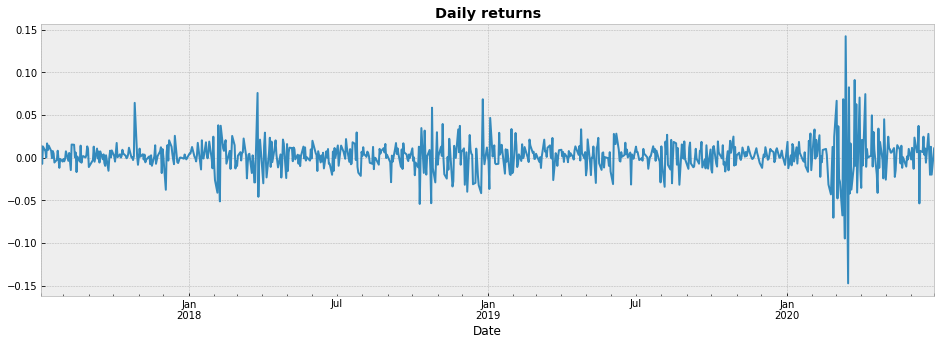

In [149]:
fig = plt.figure(figsize=(16, 5))

ret.plot()
plt.title("Daily returns", weight="bold")

plt.show()

# Use EGARCH

In [150]:
# https://arch.readthedocs.io/en/latest/univariate/introduction.html
alpha = 0.05
!pip install arch

In [151]:
from arch import arch_model 

model = arch_model(ret, 
                   mean='constant', 
                   vol='EGARCH', p=2, o=1, q=2, 
                   dist='skewstudent')

res = model.fit()

res

Iteration:      1,   Func. Count:     11,   Neg. LLF: -2127.6144962120543
Iteration:      2,   Func. Count:     32,   Neg. LLF: 79.36868589480613
Iteration:      3,   Func. Count:     50,   Neg. LLF: 76.72113285535619
Iteration:      4,   Func. Count:     63,   Neg. LLF: -134.50830746377375
Iteration:      5,   Func. Count:     77,   Neg. LLF: -333.50956617748085
Iteration:      6,   Func. Count:     92,   Neg. LLF: -360.3138556346642
Iteration:      7,   Func. Count:    104,   Neg. LLF: -543.1194203677171
Iteration:      8,   Func. Count:    116,   Neg. LLF: -823.8670797032194
Iteration:      9,   Func. Count:    131,   Neg. LLF: -974.8567873956038
Iteration:     10,   Func. Count:    143,   Neg. LLF: -1733.9099168213781
Iteration:     11,   Func. Count:    156,   Neg. LLF: -1832.8447057678118
Iteration:     12,   Func. Count:    168,   Neg. LLF: -1928.799278476779
Iteration:     13,   Func. Count:    180,   Neg. LLF: -1937.9476180609763
Iteration:     14,   Func. Count:    192,   Neg

                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                         Adj Close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:                2143.84
Distribution:      Standardized Skew Student's t   AIC:                          -4269.68
Method:                       Maximum Likelihood   BIC:                          -4228.07
                                                   No. Observations:                  752
Date:                           Fri, Sep 24 2021   Df Residuals:                      751
Time:                                   18:17:30   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

In [152]:
def calculate_VaR_garch(returns, alpha):
    
    scaling_const = 10.0 / returns.std()
    
    dist='skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='constant', 
                    vol='EGARCH', p=2, o=1, q=2, 
                    dist='skewstudent')

    res = am.fit(update_freq=0, disp='off', options={'ftol':1.2e-01})

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    return_garch_forecast = cond_mean / scaling_const
    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const

    return VaR_garch_forecast

In [153]:
calculate_VaR_garch(ret,alpha)

-0.030869498919782624

In [154]:
# This could also be accomodated to handle L_history of type pd.TimeDelta like '1 year'

def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)
    
    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)
        
    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

In [155]:
VaR_garch = calc_VaR(ret, calculate_VaR_garch, L_history=252, level=alpha)

# Use Generalized normal distribution

In [156]:
params_gennorm = ss.gennorm.fit(ret)

gen_arg = params_gennorm[-3]
gen_loc = params_gennorm[-2]
gen_scale = params_gennorm[-1]

VaR_gennorm = ss.gennorm.ppf(alpha, *params_gennorm)
ES_gennorm = ss.gennorm.expect(args=(gen_arg,), loc=gen_loc, scale=gen_scale, ub=VaR_gennorm, conditional=True)

print('Estimated parameters: arg={:.3f}, loc={:.3f}, scale={:.3f}'.format(gen_arg, gen_loc, gen_scale))
print('Value-at-Risk: {:.2f}%'.format(VaR_gennorm))
print('Expected Shortfall: {:.2f}%'.format(100*ES_gennorm))

Estimated parameters: arg=0.829, loc=0.002, scale=0.009
Value-at-Risk: -0.03%
Expected Shortfall: -4.22%


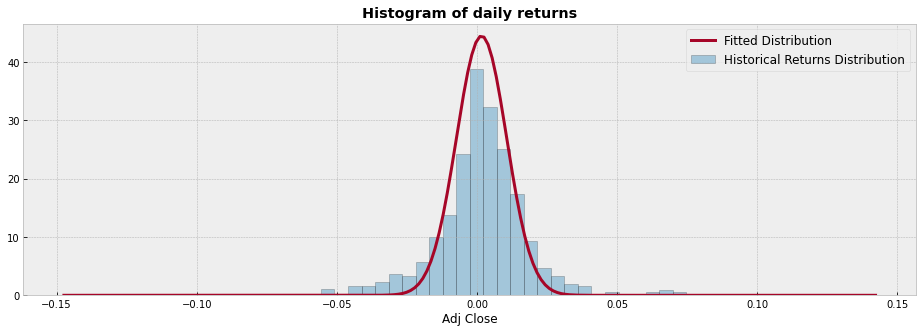

In [157]:
fig = plt.figure(figsize=(16, 5))

x = np.linspace(ret.min(), ret.max(), 200)

y_pdf = ss.norm.pdf(x, loc = gen_loc, scale = gen_scale)

sns.distplot(ret, hist=True, kde=False, 
             bins=60, norm_hist=True,
             hist_kws={'edgecolor':'black'})
plt.plot(x, y_pdf, linewidth=3)

plt.title("Histogram of daily returns", weight="bold")
plt.legend(['Fitted Distribution', 'Historical Returns Distribution'], fontsize=12)

plt.show()

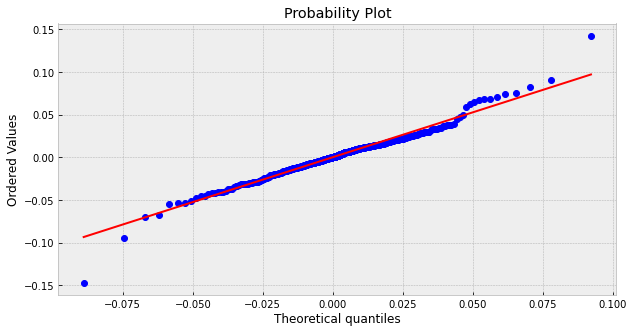

In [158]:
fig = plt.figure(figsize=(10, 5))
ss.probplot(ret, dist=ss.gennorm(*params_gennorm), plot=plt)
plt.show()

In [159]:
def calculate_VaR_gennormal(ret, alpha=0.05):

    params_gennorm = ss.gennorm.fit(ret)
    
    return ss.gennorm.ppf(alpha, *params_gennorm)

In [160]:
VaR_gennorm = calc_VaR(ret, calculate_VaR_gennormal, L_history=252, level=alpha)

# Combination of GARCH and EVT

In [161]:
def calculate_VaR_pot(ret, alpha=0.05):
    
    u = ret.quantile(0.2)
    ret_tail = ret[ret <= u]

    c, loc, scale = ss.genpareto.fit(-ret_tail, loc=0)
    
    return u - scale / c * ((alpha/(ret <= u).mean())**(-c) - 1)

In [162]:
def calculate_VaR_GARCH_EVT(returns, alpha):
    
    scaling_const = 10.0 / returns.std()

    mdl = arch_model(scaling_const * returns,
                    mean='HARX', lags=1, # mean = Constant, ARX, HARX + the number of lags
                    vol='Garch', p=1, o=1, q=1, # vol = Garch, EGARCH, HARCH + the number of lags
                    dist='normal')

    res = mdl.fit(disp='off')


    # get Standartized residuals
    stand_residuals = res.resid / res.conditional_volatility
    stand_residuals = stand_residuals.dropna()


    # forecast mean and variance one step ahead
    forecasts = res.forecast(horizon=1)
    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    # conditional stand_residuals
    conditional_sr = cond_mean + np.sqrt(cond_var) * stand_residuals
    conditional_sr = conditional_sr / scaling_const
      
    VaR_GARCH_EVT = calculate_VaR_pot(conditional_sr, alpha)
    #VaR_FHS = conditional_sr.quantile(alpha)

    return VaR_GARCH_EVT

In [163]:
VaR_GARCH_EVT = calc_VaR(ret, calculate_VaR_GARCH_EVT, L_history=252, level=alpha)

# Plot curves

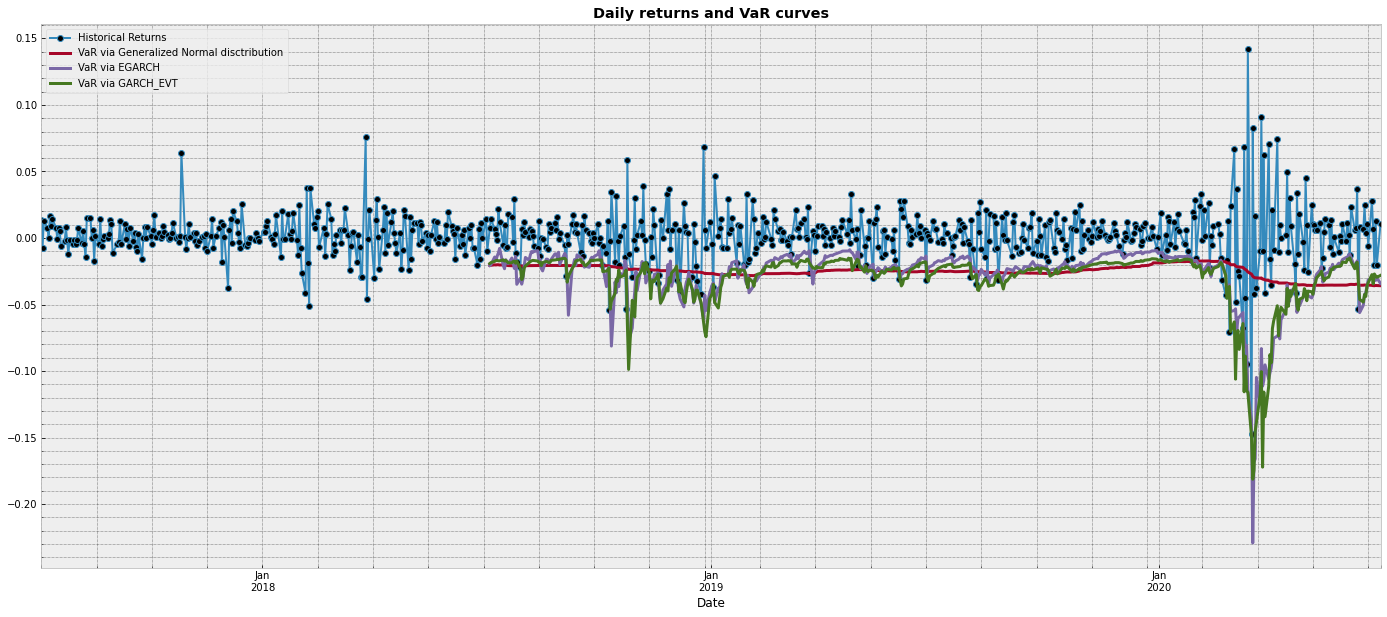

In [164]:
fig = plt.figure(figsize=(24, 10))

ret.plot(marker = 'o',
         markerfacecolor = 'black')

VaR_gennorm.plot(linewidth=3)
VaR_garch.plot(linewidth=3)
VaR_GARCH_EVT.plot(linewidth=3)

plt.title("Daily returns and VaR curves", weight="bold")
plt.minorticks_on()
plt.grid(which = 'both',
         color = 'k', 
        linestyle = ':')

plt.legend(['Historical Returns',
            'VaR via Generalized Normal disctribution',
            'VaR via EGARCH',
            'VaR via GARCH_EVT'])

plt.show()

# Backtesting VaR

In [165]:
def calc_hits(returns, VaRs):
    return ((VaRs - returns).dropna() > 0).values

In [166]:
def zone(p):
    if p > 0.05:
        return 'green'
    elif p > 0.0001:
        return 'yellow'
    else:
        return 'red'

In [167]:
def backtest_VaR(r, VaR, level, L=None):
    # to skip starting NaNs
    if L is None:
        L = (~VaR.isna()).to_numpy().nonzero()[0][0];
    r = r[L:]
    VaR = VaR[L:]
    
    hits = calc_hits(r, VaR)    
    
    p_value_two_sided = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'two-sided')
    p_value_conservative = ss.binom_test(sum(hits), len(hits), 1-level, alternative = 'greater')
    print(f'Backtesting {VaR.name}:')
    print(f'The proportion of hits is {(sum(hits)/len(hits))*100:.3}% instead of expected {(1-level)*100:.3}%')
    print(f'Two-sided p-val {p_value_two_sided:.3}, one-sided: {p_value_conservative:.3}')
    print(f'{zone(p_value_two_sided)} zone\n')

In [168]:
backtest_VaR(ret, VaR_garch, 1-alpha)
backtest_VaR(ret, VaR_gennorm, 1-alpha)
backtest_VaR(ret, VaR_GARCH_EVT, 1-alpha)

Backtesting calculate_VaR_garch:
The proportion of hits is 6.4% instead of expected 5.0%
Two-sided p-val 0.15, one-sided: 0.0945
green zone

Backtesting calculate_VaR_gennormal:
The proportion of hits is 7.8% instead of expected 5.0%
Two-sided p-val 0.00722, one-sided: 0.00461
yellow zone

Backtesting calculate_VaR_GARCH_EVT:
The proportion of hits is 5.2% instead of expected 5.0%
Two-sided p-val 0.837, one-sided: 0.447
green zone



# Conclusion

Из рассмотренных моделей лучше всех себя показывает комбинация GARCH+EVT, риски очень близко к ожидаемым(5,2%), это лучший скор. EGARCH показывает (6,4%), подальше от ожидаемого, но еще в "зеленой зоне". Обобщённое нормальное распределение показывает риск выше ожидаемого(7,8%) и находится в "желтой зоне", значит мы недооцениваем риски и можем потерять прибыль. 